Sentiment shape: (2644, 4)
Trades shape: (211224, 16)
Merged shape: (2340, 8)

Performance by sentiment:
                  daily_pnl  win_rate
classification                       
Extreme Fear    4619.439053  0.329659
Extreme Greed   5161.922644  0.386387
Fear            5328.818161  0.364033
Greed           3318.100730  0.343559
Neutral         3438.618818  0.355414

Behavior by sentiment:
                  n_trades     avg_size  long_ratio
classification                                     
Extreme Fear    133.750000  6773.464125    0.531533
Extreme Greed    76.030418  5371.637182    0.473116
Fear             98.153968  8975.928546    0.518967
Greed            77.628086  6427.866594    0.471594
Neutral         100.228723  6963.694861    0.472431


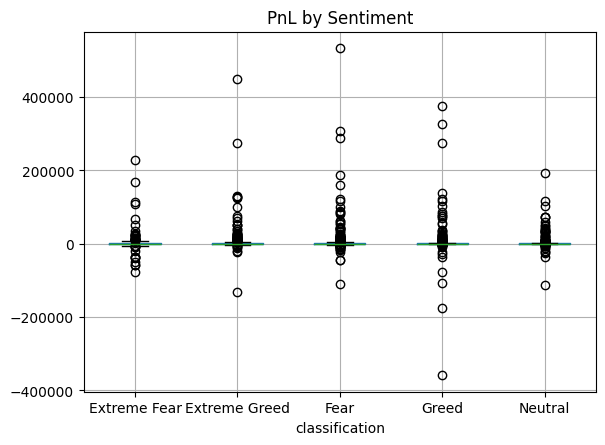

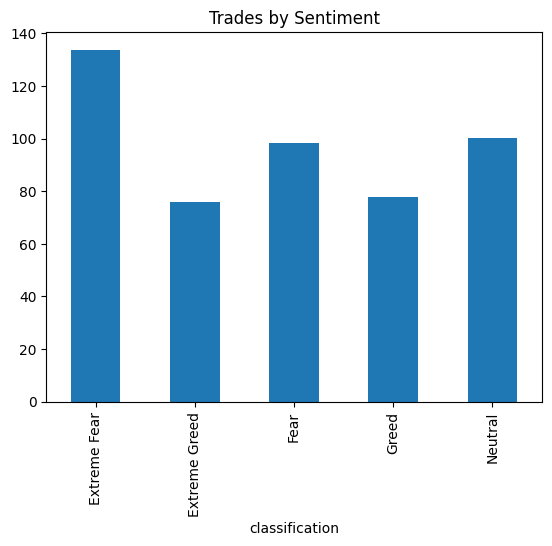


Model Accuracy: 0.8055555555555556


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# LOAD
sent = pd.read_csv("S:/market-sentiment-vs-trader-performance/fear_greed_index.csv")
trades = pd.read_csv("S:/market-sentiment-vs-trader-performance/historical_data.csv")

sent.columns = sent.columns.str.strip()
trades.columns = trades.columns.str.strip()

print("Sentiment shape:", sent.shape)
print("Trades shape:", trades.shape)

# =====================
# DATE HANDLING
# =====================

sent['date'] = pd.to_datetime(sent['date']).dt.date

trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True
)

trades['date'] = trades['Timestamp IST'].dt.date

# =====================
# FEATURE ENGINEERING
# =====================

trades['win'] = trades['Closed PnL'] > 0
trades['long'] = (trades['Side'] == "BUY").astype(int)

daily = trades.groupby(['Account','date']).agg(
    daily_pnl=('Closed PnL','sum'),
    win_rate=('win','mean'),
    avg_size=('Size USD','mean'),
    n_trades=('Account','count'),
    long_ratio=('long','mean')
).reset_index()

# =====================
# MERGE
# =====================

df = daily.merge(
    sent[['date','classification']],
    on='date',
    how='left'
)

df.dropna(inplace=True)

print("Merged shape:", df.shape)

# =====================
# ANALYSIS
# =====================

print("\nPerformance by sentiment:")
print(df.groupby('classification')[['daily_pnl','win_rate']].mean())

print("\nBehavior by sentiment:")
print(df.groupby('classification')[['n_trades','avg_size','long_ratio']].mean())

# =====================
# CHARTS
# =====================

df.boxplot(column='daily_pnl', by='classification')
plt.title("PnL by Sentiment")
plt.suptitle("")
plt.show()

df.groupby('classification')['n_trades'].mean().plot(kind='bar')
plt.title("Trades by Sentiment")
plt.show()

# =====================
# BONUS MODEL
# =====================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

df['profitable'] = (df['daily_pnl'] > 0).astype(int)

X = df[['avg_size','n_trades','long_ratio']]
X = pd.concat([X, pd.get_dummies(df['classification'], drop_first=True)], axis=1)

y = df['profitable']

X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)

model = RandomForestClassifier()
model.fit(X_train,y_train)

print("\nModel Accuracy:", model.score(X_test,y_test))



In [8]:
print(sent.columns)
print(trades.columns)


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [5]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


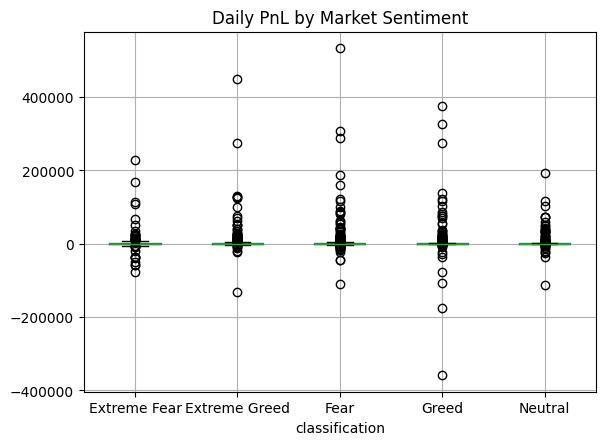

In [8]:
df.boxplot(column='daily_pnl', by='classification')
plt.title("Daily PnL by Market Sentiment")
plt.suptitle("")
plt.show()


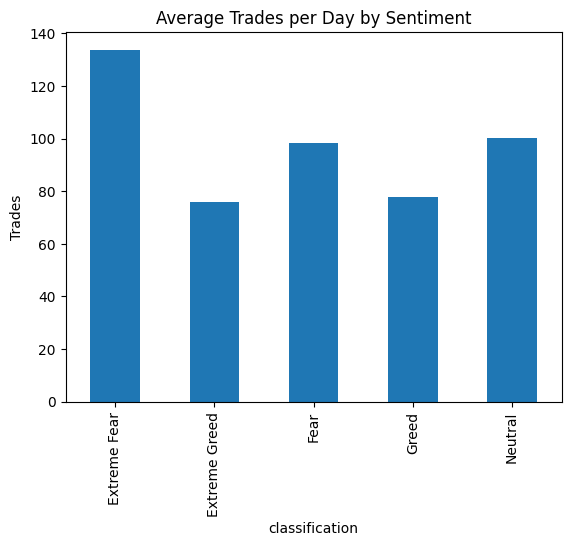

In [9]:
df.groupby('classification')['n_trades'].mean().plot(kind='bar')
plt.title("Average Trades per Day by Sentiment")
plt.ylabel("Trades")
plt.show()


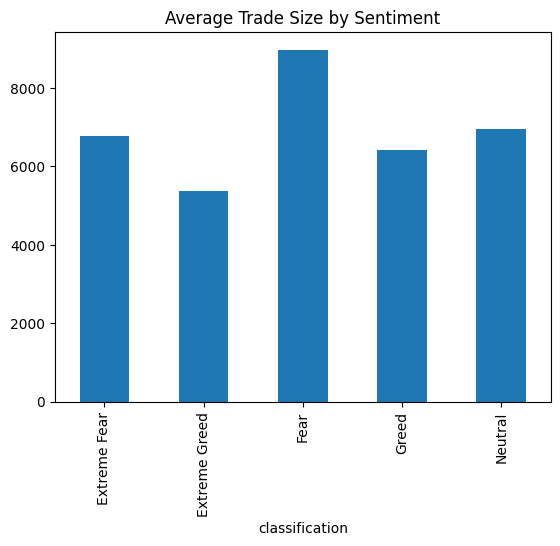

In [10]:
df.groupby('classification')['avg_size'].mean().plot(kind='bar')
plt.title("Average Trade Size by Sentiment")
plt.show()


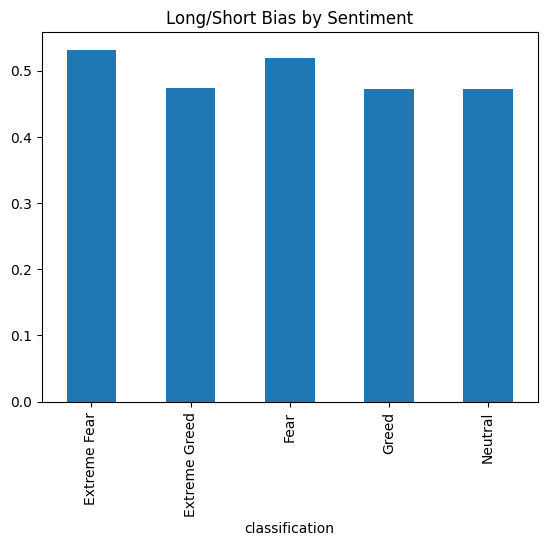

In [11]:
df.groupby('classification')['long_ratio'].mean().plot(kind='bar')
plt.title("Long/Short Bias by Sentiment")
plt.show()


In [13]:
perf_table = df.groupby('classification')[[
    'daily_pnl','win_rate'
]].mean()

print(perf_table)


                  daily_pnl  win_rate
classification                       
Extreme Fear    4619.439053  0.329659
Extreme Greed   5161.922644  0.386387
Fear            5328.818161  0.364033
Greed           3318.100730  0.343559
Neutral         3438.618818  0.355414


In [14]:
behavior_table = df.groupby('classification')[[
    'n_trades','avg_size','long_ratio'
]].mean()

print(behavior_table)


                  n_trades     avg_size  long_ratio
classification                                     
Extreme Fear    133.750000  6773.464125    0.531533
Extreme Greed    76.030418  5371.637182    0.473116
Fear             98.153968  8975.928546    0.518967
Greed            77.628086  6427.866594    0.471594
Neutral         100.228723  6963.694861    0.472431


In [15]:
df['freq_segment'] = np.where(
    df['n_trades'] > df['n_trades'].median(),
    'Frequent','Infrequent'
)

segment_table = df.groupby('freq_segment')['daily_pnl'].mean()

print(segment_table)


freq_segment
Frequent      7564.474676
Infrequent    1221.728686
Name: daily_pnl, dtype: float64
